### Imports

In [2]:
# !pip install --upgrade category_encoders rich catboost
from rich.console import Console
console = Console()
print = console.print
from wrangling import X, y

In [3]:
import time
import math
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import matplotlib.pyplot as plt

import yellowbrick as yb
from yellowbrick.features import Rank1D
from yellowbrick.regressor import AlphaSelection, PredictionError, ResidualsPlot
from yellowbrick.datasets import load_energy
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.style import set_palette

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lars
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import OrthogonalMatchingPursuit

from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.svm import LinearSVR

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.isotonic import IsotonicRegression

import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
import catboost as ctb

from hyperopt import STATUS_OK, STATUS_FAIL, Trials, fmin, hp, tpe

np.set_printoptions(precision=3, suppress=True)
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import warnings
warnings.filterwarnings('ignore')

/Users/codyreece/Desktop/Repos/airbnb/air-scrape/venv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=21)

In [5]:
plt.style.context('dark_background')
set_palette('sns_bright')

cm = sns.color_palette("blend:white,#00ff77", as_cmap=True)

def headd(i):
    return i.style.background_gradient(cmap = cm,axis=None)

### Visuals

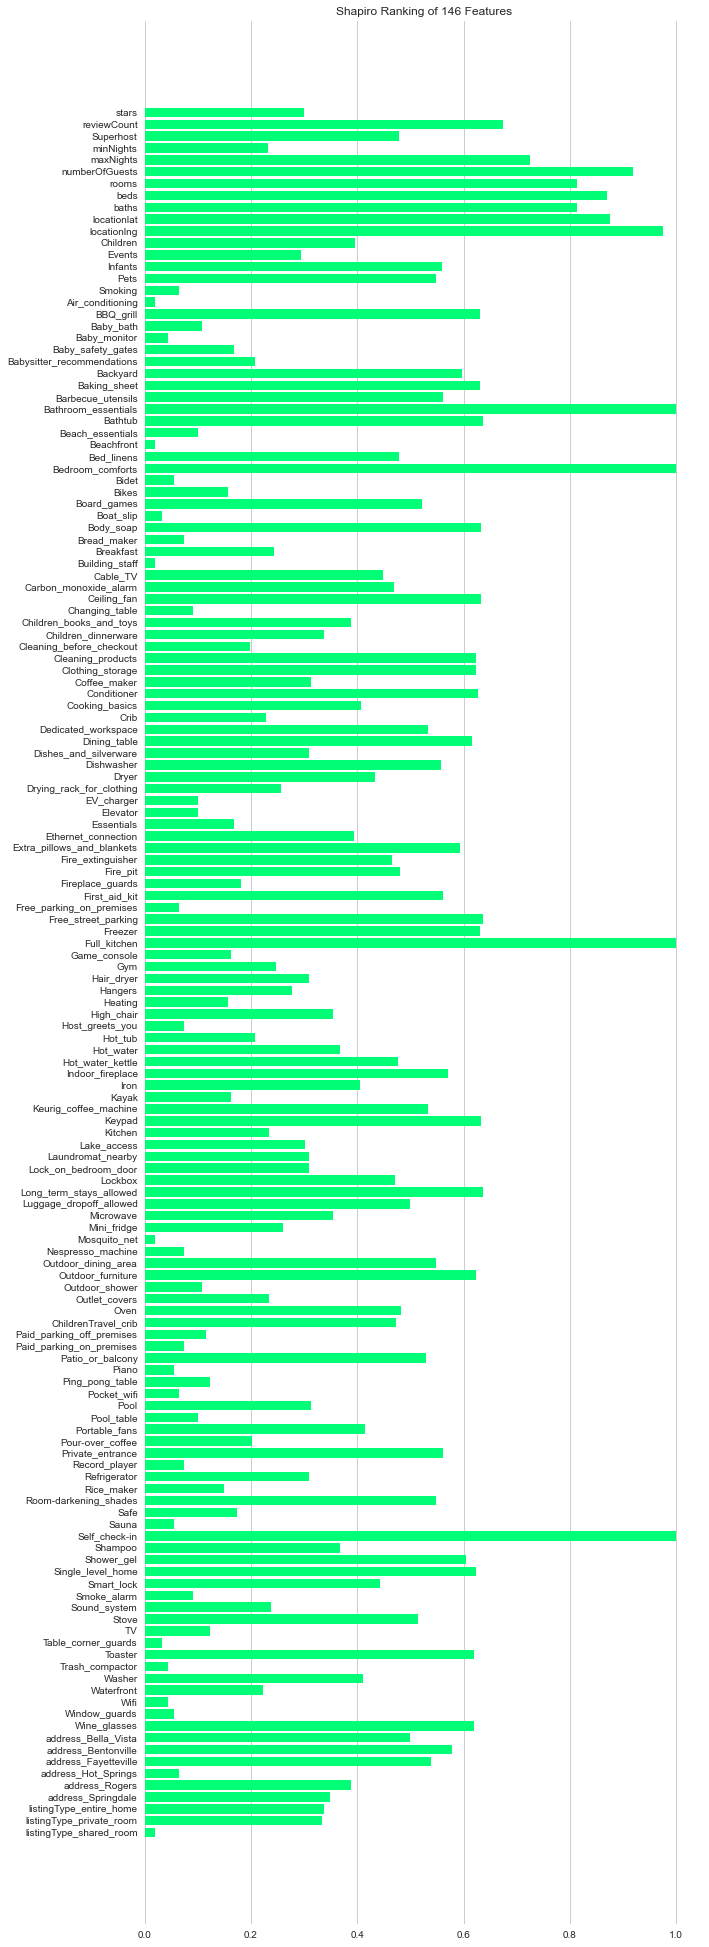

In [6]:
## Ranking the features

fig, ax = plt.subplots(1, figsize=(10, 35))
vzr = Rank1D(ax=ax, color='#00ff77')
vzr.fit(X_train, y_train)
vzr.transform(X_train)
sns.despine(left=True, bottom=True)
vzr.poof();

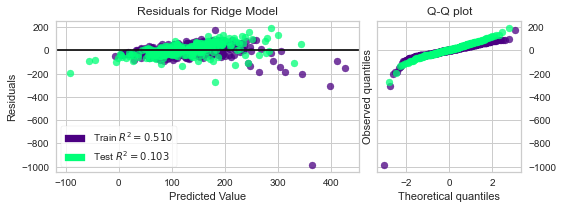

In [7]:
# Showing the Residuals, differences between observed and predicted values of data 
# the 'delta' between the actual target value and the fitted value. Residual is a crucial concept in regression problems

model = Ridge()
visualizer = ResidualsPlot(
    model,
    hist=False,
    qqplot=True,
    size=(600, 200),
    train_color="indigo",
    test_color="#00ff77", 
    )

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
# visualizer.score(X_test, y_test)
g = visualizer.poof();

In [8]:
X_outliers = pd.DataFrame(index=X.columns, columns=['outliers', 'outliers%'])

for col in X.columns:
    if any(x in str(X[col].dtype)for x in ['int', 'float', 'int64', 'uint8']):
        
        X_outliers.loc[col, 'count'] = len(X)
        X_outliers.loc[col, 'q1'] = X[col].quantile(0.25)
        X_outliers.loc[col, 'q3'] = X[col].quantile(0.75)
        X_outliers.loc[col, 'iqr'] = X_outliers.loc[col, 'q3'] - X_outliers.loc[col, 'q1']
        X_outliers.loc[col, 'lower'] = X_outliers.loc[col, 'q1'] - (3 * X_outliers.loc[col, 'iqr'])
        X_outliers.loc[col, 'upper'] = X_outliers.loc[col, 'q3'] + (3 * X_outliers.loc[col, 'iqr'])
        X_outliers.loc[col, 'min'] = X[col].min()
        X_outliers.loc[col, 'max'] = X[col].max()
        X_outliers.loc[col, 'outliers'] = ((X[col] < X_outliers.loc[col, 'lower']) | (X[col] > X_outliers.loc[col,'upper'])).sum()
        X_outliers.loc[col, 'outliers%'] = np.round(X_outliers.loc[col,
        'outliers'] / len(X) *100)
        
# headd(X_outliers.head(10))

You dropped 0 rows.

Dataset has 832 rows, 146 columns.

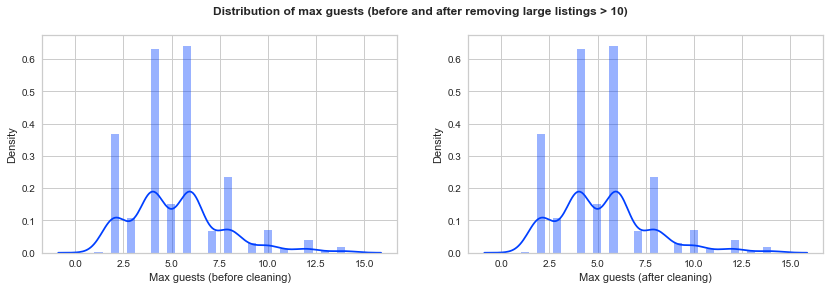

In [9]:
#Distribution of price
%matplotlib inline

fig, axs = plt.subplots(ncols=2, figsize=(14, 4))
fig.suptitle('Distribution of max guests (before and after removing large listings > 10)', weight='bold', fontsize=12)

# Before cleaning
x_axis=X['numberOfGuests'].dropna()
sns.distplot(pd.Series(x_axis, name='Max guests (before cleaning)'), ax=axs[0])

# Remove where price > 1000
condition = X[X['numberOfGuests'] > 400]
rows_to_drop = condition.index
print("You dropped {} rows.".format(condition.shape[0]))
X = X.drop(rows_to_drop, axis=0)
print("Dataset has {} rows, {} columns.".format(*X.shape))

#After cleaning
x_axis=X['numberOfGuests'].dropna()
sns.distplot(pd.Series(x_axis, name='Max guests (after cleaning)'), ax=axs[1]);

In [10]:
## Adding est. Annual Revenue
print("Dataset has {} rows, {}  before engineering.".format(*X.shape))
avg_occupancy_per_week = 4
X['yield'] = avg_occupancy_per_week * y  * 52

# cols_to_drop = ['cleaning_fee']
# df = df.drop(cols_to_drop, axis = 1)
print("Dataset has {} rows, {} columns.".format(*X.shape))


Dataset has 832 rows, 146  before engineering.

Dataset has 832 rows, 147 columns.

### Linear Regression

In [11]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [12]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [13]:
y_pred = model.predict(X_test)

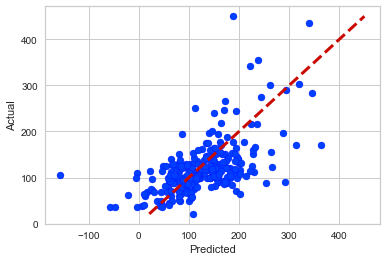

In [14]:
fig, ax = plt.subplots()
ax.scatter(y_pred, y_test, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show();

In [15]:
# model evaluation for testing set

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)


print("The model performance for testing set")
print("--------------------------------------")
print('MAE:  {}'.format(round(mae)))
print('MSE:  {}'.format(round(mse)))
print('RMSE: {}'.format(round(rmse)))
print('R2:   {}'.format(round(r2, 3)))

The model performance for testing set

--------------------------------------

MAE:  44

MSE:  3616

RMSE: 60

R2:   -0.011

### Multiple Models

In [16]:
regressors = {
    "XGBRegressor": XGBRegressor(),
    "RandomForestRegressor": RandomForestRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "SVR": SVR(),
    "NuSVR": NuSVR(),
    "LinearSVR": LinearSVR(),
    "KernelRidge": KernelRidge(),
    "LinearRegression": LinearRegression(),
    "Ridge":Ridge(),
    "HuberRegressor": HuberRegressor(),
    "PassiveAggressiveRegressor": PassiveAggressiveRegressor(),
    "ARDRegression": ARDRegression(),
    "BayesianRidge": BayesianRidge(),
    "ElasticNet": ElasticNet(),
    "OrthogonalMatchingPursuit": OrthogonalMatchingPursuit(),
}


In [17]:
df_models = pd.DataFrame(columns=['Model', 'Run_Time', 'MAE', 'MSE', 'R2', 'RMSE', 'RMSE_CV'])

for key in regressors:

    print('✓',key)

    start_time = time.time()

    regressor = regressors[key]

    model = regressor.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    scores = cross_val_score(model, 
                             X_train, 
                             y_train,
                             scoring="neg_mean_squared_error", 
                             cv=10)

    row = {'Model': key,
           'Run_Time': format(round((time.time() - start_time)/60,2)),
           'MAE': round(mean_absolute_error(y_test, y_pred)),
           'MSE': round(mean_squared_error(y_test, y_pred)),
           'R2': round(r2_score(y_test, y_pred), 3),
           'RMSE': round(np.sqrt(mean_squared_error(y_test, y_pred))),
           'RMSE_CV': round(np.mean(np.sqrt(-scores)))
    }
    
    df_models = df_models.append(row, ignore_index=True)
    df_models

✓ XGBRegressor

✓ RandomForestRegressor

✓ DecisionTreeRegressor

✓ SVR

✓ NuSVR

✓ LinearSVR

✓ KernelRidge

✓ LinearRegression

✓ Ridge

✓ HuberRegressor

✓ PassiveAggressiveRegressor

✓ ARDRegression

✓ BayesianRidge

✓ ElasticNet

✓ OrthogonalMatchingPursuit

In [18]:
df_models.sort_values(by='RMSE_CV', ascending=True)

,Model,Run_Time,MAE,MSE,R2,RMSE,RMSE_CV
1,RandomForestRegressor,0.22,32,2683,0.249,52,60
12,BayesianRidge,0.01,35,2333,0.347,48,63
9,HuberRegressor,0.08,30,2081,0.418,46,65
11,ARDRegression,0.69,38,2705,0.243,52,65
13,ElasticNet,0.01,35,2328,0.349,48,65
14,OrthogonalMatchingPursuit,0.01,37,2691,0.247,52,66
6,KernelRidge,0.01,42,3206,0.103,57,68
8,Ridge,0.01,42,3208,0.103,57,68
7,LinearRegression,0.01,44,3616,-0.011,60,71
0,XGBRegressor,0.15,39,9456,-1.645,97,74


### Focusing on XGB

In [19]:
hyperparameter_grid = {
    'n_estimators': [100],
    'max_depth': [2, 3, 5],
    'learning_rate': [.001,.01]
    }

In [20]:
random_cv = RandomizedSearchCV(
    estimator=XGBRegressor(),
    param_distributions=hyperparameter_grid,
    cv=3,
    n_iter=30,
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1,
    verbose = 0, 
    return_train_score = True,
    random_state=13
    )

random_cv.fit(X_train,y_train)

random_cv.best_estimator_

/Users/codyreece/Desktop/Repos/airbnb/air-scrape/venv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/codyreece/Desktop/Repos/airbnb/air-scrape/venv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/codyreece/Desktop/Repos/airbnb/air-scrape/venv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/codyreece/Desktop/Repos/airbnb/air-scrape/venv/lib/python3.9/site-packages/xgboost/compat.

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [21]:
regressor = random_cv.best_estimator_
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)

In [22]:
# model evaluation for testing set

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE:  {}'.format(round(mae)))
print('MSE:  {}'.format(round(mse)))
print('RMSE: {}'.format(round(rmse)))
print('R2:   {}'.format(round(r2, 3)))

The model performance for testing set

--------------------------------------

MAE:  46

MSE:  4282

RMSE: 65

R2:   -0.198

In [23]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': np.around(y_pred)})
df

,Actual,Predicted
id,,
52953805,99.0,85.0
53956556,164.0,85.0
52199629,125.0,85.0
38351537,118.0,69.0
49962363,354.0,95.0
...,...,...
23641632,130.0,69.0
28240973,83.0,85.0
34969229,98.0,63.0
